# 1D finite volume diffusion

(inspired by Versteeg example 4.2)

The 1D diffusion equation is:

$$ \frac{d}{dx}\left( k  \frac{dT}{dx}\right) + q = 0$$

<img src="diffusion1Dgrid.png">

Integrate using Gauss' law:

$$  \left[ \left(  k  \frac{dT}{dx} \right)_e - \left(  k  \frac{dT}{dx} \right)_w \right] A + q A \delta x = 0$$

Assume $k$ is a constant and discretize gradients with central difference:

$$  \left[ \left(  \frac{T_E - T_P}{\delta x} \right) - \left(  \frac{T_P - T_W}{\delta x} \right) \right] k A + q A \delta x = 0$$

$$ \Rightarrow   \underbrace{\frac{k A}{\delta x}}_{a_E} T_E   + \underbrace{\frac{k A}{\delta x}}_{a_W} T_W  + \underbrace{q A \delta x}_{S_u} = \underbrace{\frac{2 k A}{\delta x}}_{a_P} T_P$$

Notice, $a_P = a_E + a_W$, although this is not always the case.

Special care is needed for the boundary nodes, where the boundary conditions $T_A$ and $T_B$ apply. First node 1:

$$  \left[ \left(  \frac{T_E - T_P}{\delta x} \right) - \left(  \frac{T_P - T_A}{\delta x / 2} \right) \right] k A + q A \delta x = 0$$

$$ \Rightarrow   \underbrace{\frac{k A}{\delta x}}_{a_E} T_E   + \underbrace{0}_{a_W} T_W  + \underbrace{q A \delta x +  \frac{2 T_A k A}{\delta x }}_{S_u} = \underbrace{\frac{3 k A}{\delta x}}_{a_P} T_P$$

Then node 5:


$$  \left[ \left(  \frac{T_B - T_P}{\delta x /2} \right) - \left(  \frac{T_P - T_W}{\delta x } \right) \right] k A + q A \delta x = 0$$

$$ \Rightarrow   \underbrace{0}_{a_E} T_E   + \underbrace{\frac{k A}{\delta x}}_{a_W} T_W  + \underbrace{q A \delta x +  \frac{2 T_B k A}{\delta x }}_{S_u} = \underbrace{\frac{3 k A}{\delta x}}_{a_P} T_P$$

Finally, we need to decide on the parameters:

- $L = 0.02~\mathrm{m} \Rightarrow \delta x = 0.004~\mathrm{m}$ 
- $A = 1~\mathrm{m}^2$ 
- $k = 0.5~\frac{\mathrm{W}}{\mathrm{m} \cdot \mathrm{K}}$
- $q = 10^6~\frac{\mathrm{W}}{\mathrm{m}^3}$
- $T_A = 100~\mathrm{K}$
- $T_B = 200~\mathrm{K}$

A matrix system can now be assembled and solved.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from scipy.optimize import fsolve
import time
mpl.style.use('classic')
# Latex font
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 15
plt.rcParams["legend.scatterpoints"] = 1
plt.rcParams["legend.numpoints"] = 1
yd = dict(rotation=0,ha='right') # I couldn't find a way to customize these, so use a dict everytime..

In [2]:
## Constants
N = 20
L = 0.02; dx = L/N
A = 1
k = 0.5
q = 1e6
T_A = 100
T_B = 200


## Tri-diagonal matrix shortcut
def tridiag(a1, a2, a3, k1=-1, k2=0, k3=1):
    '''
    Create N x N tri-diagonal matrix
    a1 is the lower-diagonal (size N-1)
    a2 is the diagonal       (size N)
    a3 is the upper-diagonal (size N-1)
    Don't touch the k's!
    '''
    return np.diag(a1, k1) + np.diag(a2, k2) + np.diag(a3, k3)


## Assemble matrix
a1 = np.ones(N-1)*(-k*A/dx)   # Corresponds to the a_W coefficients
a2 = np.ones(N)*2*k*A/dx      # Corresponds to the a_P coefficients
a2[0] = 3*k*A/dx; a2[-1] = 3*k*A/dx; 
a3 = np.ones(N-1)*(-k*A/dx)   # Corresponds to the a_E coefficients
# Minus on a1 and a3, because they are moved to other side of equality
a = tridiag(a1,a2,a3)


## Assemble b-vector
b = np.ones(N)*q*A*dx
b[0] = q*A*dx + 2*T_A*k*A/dx; b[-1] = q*A*dx + 2*T_B*k*A/dx; 



## Print to screen
print('A matrix:')
print(a)

print('\nb vector:')
print(b)

A matrix:
[[1500. -500.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [-500. 1000. -500.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0. -500. 1000. -500.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0. -500. 1000. -500.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0. -500. 1000. -500.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. -500. 1000. -500.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0. -500. 1000. -500.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0. -500. 1000. -500.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    

## Solution of matrix system

Many mathetical methods exist to solve matrix systems:

- Built-in python routine, inv(A)
- TDMA
- Jacobi
- Gauss-Seidel
- Multigrid-accelerated Jacobi

These will now be tested and compared to the exact analytical solution:

$$ T = \left[ \frac{T_B - T_A}{L} +  \frac{q}{2 k} (L - x) \right] x + T_A$$


Built-in inv(A) time: 0.00e+00 s
TDMA time: 0.00e+00 s
Jacobi time: 9.97e-04 s
Gauss-Seidel time: 8.02e-03 s
Gauss-Seidel time: 6.98e-03 s


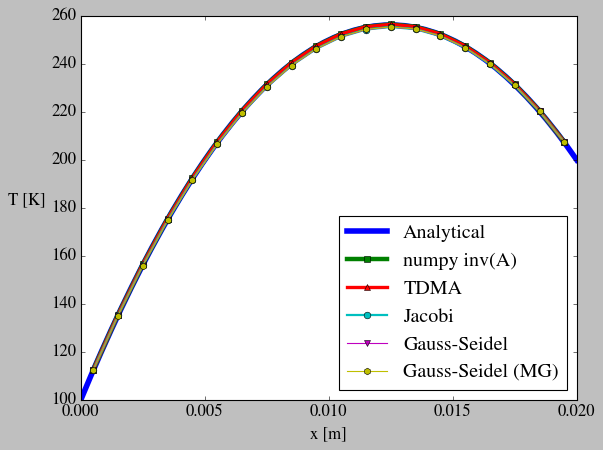

In [52]:
## Analytical solution
x = np.linspace(0,L,50)
T_an = ((T_B - T_A)/L + q/(2*k)*(L-x))*x + T_A


## Built-in solution
x_cell = np.linspace(dx/2,L-dx/2,N)
t = time.time()
T_bi = np.matmul(np.linalg.inv(a), b)
print('Built-in inv(A) time: %.2e s'%(time.time() - t))

## TDMA algorithm
def TDMA(a1,a2,a3,b):
    '''
    Implementation of the TDMA algorithm (Versteeg p.216) for tri-diagonal matrix systems
    a1 is the lower-diagonal (size N-1)
    a2 is the diagonal       (size N)
    a3 is the upper-diagonal (size N-1)
    '''
    N = len(b)
    beta = -a1; beta = np.insert(beta,0,0)
    D = a2
    alpha = -a3; alpha = np.append(alpha,0)
    C = b
 

    # Forward substitution
    A = np.zeros(N)
    Cp = np.zeros(N)
    for j in range(N):
        if(j==0):
            A[j] = alpha[j]/D[j]
            Cp[j] = C[j]/D[j]
        elif(j==(N-1)):
            A[j] = 0
            # Because A_N is always 0
            Cp[j] = (beta[j]*Cp[j-1] + C[j])/(D[j] - beta[j]*A[j-1])
        else:
            A[j] = alpha[j]/(D[j] - beta[j]*A[j-1])
            Cp[j] = (beta[j]*Cp[j-1] + C[j])/(D[j] - beta[j]*A[j-1])
    
    
    # Back substitution
    phi_sol = np.zeros(N)
    for j in reversed(range(N)):
        if(j==N-1):
            phi_sol[j] = Cp[j]
        else:
            phi_sol[j] = A[j]*phi_sol[j+1] + Cp[j]

            
    # Return solution        
    return phi_sol   
          
## Test of TDMA with example from p.217 of Versteeg
#a1test = np.array([-5,-5,-5,-5])
#a2test = np.array([20,15,15,15,10])
#a3test = np.array([-5,-5,-5,-5])
#btest = np.array([1100,100,100,100,100])
#phitest = TDMA(a1test,a2test,a3test,btest)
#print(phitest)


## TDMA solution
t = time.time()
T_TDMA = TDMA(a1,a2,a3,b)
print('TDMA time: %.2e s'%(time.time() - t))

## Jacobi algorithm
def Jacobi(A,b,phi0,Nit=10):
    '''
    Solve A*phi=b with the Jacobi method (p.224)
    A is size N x N
    b is size N
    phi0 is the initial guess (size N)
    '''
    
    Aii = np.diag(A)            # Vector of size N
    T = -A/Aii[:,None]          # Divide row with diagonal element (size N x N)
    np.fill_diagonal(T,0)       # .. and set diagonal to 0
    c = b/Aii
    
    for i in range(Nit):
        if(i==0):
            phi = np.matmul(T,phi0) + c
        else:
            phi = np.matmul(T,phi) + c

    # Return solution of Nit iterations
    return phi

# Test of Jacobi (p.224)
#Atest = np.array([[2, 1, 1],[-1, 3, -1], [1, -1, 2]])
#btest = np.array([7, 2, 5])
#phi0test = np.array([0, 0, 0])
#phitest = Jacobi(Atest, btest, phi0test, Nit=17)
#print(phitest)


## Jacobi solution
t = time.time()
T_Jac = Jacobi(a, b, phi0=np.ones(N)*100, Nit=400)
print('Jacobi time: %.2e s'%(time.time() - t))

# Gauss-Seidel algorithm
def GaussSeidel(A,b,phi0,Nit=10):
    '''
    Solve A*phi=b with the Gauss-Seidel method (p.225)
    A is size N x N
    b is size N
    phi0 is the initial guess (size N)
    '''
    N = len(b)
    Aii = np.diag(A)            # Vector of size N
    T = -A/Aii[:,None]          # Divide row with diagonal element (size N x N)
    np.fill_diagonal(T,0)       # .. and set diagonal to 0
    T1 = np.tril(T,-1)          # Extract lower triangular part of matrix
    T2 = np.triu(T,1)           # Extract upper triangular part of matrix
    c = b/Aii
    
    
    phi = np.copy(phi0)
    for k in range(Nit):
        if(k==0):
            phi2 = np.matmul(T2,phi0) + c
        else:
            phi2 = np.matmul(T2,phi) + c
        for i in range(N):
            phi[i] = np.dot(T1[i,:],phi) + phi2[i]
                            
    # Return solution of Nit iterations
    return phi

# Test of Gauss-Seidel (p.226)
#Atest = np.array([[2, 1, 1],[-1, 3, -1], [1, -1, 2]])
#btest = np.array([7, 2, 5])
#phi0test = np.array([0.0, 0.0, 0.0])
#phi = GaussSeidel(Atest, btest, phi0test, Nit=13)
#print(phi)


## Gauss-Seidel solution
t = time.time()
T_Gau = GaussSeidel(a, b, phi0=np.ones(N)*100, Nit=200)
print('Gauss-Seidel time: %.2e s'%(time.time() - t))


## Multigrid algorithm

def create_tridiag_matrix(a1,a2,a3,N,a2_1,a2_N):
    '''
    Create a tridiag type of matrix
    a1 = value at lower diagonal (scalar)
    a2 = value at diagonal (scalar)
    a3 = value at upper diagonal (scalar)
    N = size of matrix (scalar)
    a2_1 = element 1,1 (scalar)
    a2_N = element N,N (scalar)
    '''
    a1vec = np.ones(N-1)*a1   
    a2vec = np.ones(N)*a2
    a2vec[0] = a2_1; a2vec[-1] = a2_N
    a3vec = np.ones(N-1)*a3  
    return tridiag(a1vec, a2vec, a3vec)

def multigrid_cycle(Ah,A2h,A4h,b,phi0):
    # Step 1: Solve system a few iterations with Gauss-Seidel and calculate residuals
    yh = GaussSeidel(Ah, b, phi0, Nit=5)
    rh = b - np.matmul(Ah, yh)
    
    # Step 2a: Restriction of residuals to level 2h
    r2h = np.zeros(int(len(rh)/2))
    for i in range(len(r2h)):
        r2h[i] = (rh[2*i] + rh[2*i+1])/2
    
    # Step 2b: Calculate errors at level 2h using 10 iterations of Gauss-Seidel and correct r2h residual
    e2h = GaussSeidel(A2h, r2h, np.zeros(len(r2h)), Nit=10)
    r2hh = r2h - np.matmul(A2h,e2h)  # "hh" = "h hat"
    
    # Step 2c: Restriction of corrected residuls to level 4h
    r4h = np.zeros(int(len(r2hh)/2))
    for i in range(len(r4h)):
        r4h[i] = (r2hh[2*i] + r2hh[2*i+1])/2
        
    # Step 2d: Calculate errors at level 4h using 10 iterations
    e4h = GaussSeidel(A4h, r4h, np.zeros(len(r4h)), Nit=10)
    
    # Step 3a: Prolongation to level 2h and correction of e2h error
    e2hp = np.zeros(int(len(e2h)))
    for i in range(len(e2hp)):
        if(i == 0):
            e2hp[i] = 0.75*e4h[0]
        elif(i == len(e2hp)-1):
            e2hp[i] = 0.75*e4h[-1]
        else:
            if(i % 2 == 0):
                e2hp[i] = 0.25*e4h[i//2 - 1] + 0.75*e4h[i//2]
            else:
                e2hp[i] = 0.75*e4h[i//2] + 0.25*e4h[i//2 + 1]
    
    e2hc = e2h + e2hp
    
    # Step 3b: Do 2 Gauss-Seidel iterations on the corrected level 2h error
    e2h = GaussSeidel(A2h, r2h, e2hc, Nit=2)
    
    
    # Step 3c: Prolongation to level h and calculation of error at level h
    eh = np.zeros(len(rh))
    for i in range(len(eh)):
        if(i == 0):
            eh[i] = 0.75*e2h[0]
        elif(i == len(eh)-1):
            eh[i] = 0.75*e2h[-1]
        else:
            if(i % 2 == 0):
                eh[i] = 0.25*e2h[i//2 - 1] + 0.75*e2h[i//2]
            else:
                eh[i] = 0.75*e2h[i//2] + 0.25*e2h[i//2 + 1]
    
    # Step 4a: Correction of initial solution from step 1
    yc = yh + eh
    
    # Step 4b: Final iterations
    yfinal = GaussSeidel(Ah, b, yc, Nit=2)
    return yfinal


# Example from p.233
#a1test = np.ones(20-1)*(-1)   
#a2test = np.ones(20)*2
#a2test[0] = 3; a2test[-1] = 3
#a3test = np.ones(20-1)*(-1)  
#Ah = create_tridiag_matrix(-1,2,-1,20,3,3)
#A2h = create_tridiag_matrix(-0.5,1,-0.5,10,1.5,1.5)
#A4h = create_tridiag_matrix(-0.25,0.5,-0.25,5,0.75,0.75)
#btest = np.ones(20)*10; btest[0]=210; btest[-1]=1010
#phi0test = np.ones(20)*150
#ytest = multigrid_cycle(Ah,A2h,A4h,btest,phi0test)
#print(ytest)


## Multigrid accelerated Gauss-Seidel
Ah = np.copy(a)
A2h = create_tridiag_matrix((-k*A/dx)/2,(2*k*A/dx)/2,(-k*A/dx)/2,N//2,(3*k*A/dx)/2,(3*k*A/dx)/2)
A4h = create_tridiag_matrix((-k*A/dx)/4,(2*k*A/dx)/4,(-k*A/dx)/4,N//4,(3*k*A/dx)/4,(3*k*A/dx)/4)
N_cycles = 7
t = time.time()
for i in range(N_cycles):
    if(i==0):
        T_MG = multigrid_cycle(Ah,A2h,A4h,b,phi0=np.ones(N)*100)
    else:
        T_MG = multigrid_cycle(Ah,A2h,A4h,b,phi0=T_MG)
print('Gauss-Seidel time: %.2e s'%(time.time() - t))
        
        
## Plot solutions

fig = plt.figure()
plt.plot(x,T_an,linewidth=5,label='Analytical')
plt.plot(x_cell,T_bi,'s-',linewidth=4,label='numpy inv(A)')
plt.plot(x_cell,T_TDMA,'^-',linewidth=3,label='TDMA')
plt.plot(x_cell,T_Jac,'o-',linewidth=2,label='Jacobi')
plt.plot(x_cell,T_Gau,'v-',linewidth=1,label='Gauss-Seidel')
plt.plot(x_cell,T_MG,'h-',linewidth=1,label='Gauss-Seidel (MG)')
plt.xlabel('x [m]')
plt.ylabel('T [K]',yd)
plt.legend(loc='lower right')


### Disclaimer for the implementations in this notebook

The above implementations were *not* written in the most efficient way. Also, no parallelization was used!

In the HPC course, we solved the 2D diffusion problem with a MPI parallelized Jacobi method implemented in FORTRAN.